In [1]:
import data_utils as util
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd

# data preprocessing

In [19]:
#######################################################
# Load the feature header
#######################################################
import csv

# read the csv file
feature_names = []
with open('./data/header.csv') as f:
    reader = csv.reader(f)
    for line in reader:
        feature_names.append(line)

# Dirty tricks to clean up the feature names
feature_names = feature_names[0]
feature_names = list(map(lambda x: x.replace(' ', '_'), feature_names))
feature_names[0] = 'PharmGKB_Subject_ID' # manual fix to remove a character in f...[0]

In [20]:
####################################################################
# Load the dataframe into X; clean up some unnecessary columns 
####################################################################

# Load data and process column names
df = pd.read_csv('./data/warfarin_with_dose.csv', names = feature_names)
#keep_default_na=False)
df.columns = [c.replace(' ', '_') for c in df.columns]

# Extract the label (Warfarin dose) from the rest of the features
y = df.Therapeutic_Dose_of_Warfarin
X = df.drop('Therapeutic_Dose_of_Warfarin',axis=1)
feature_names.remove('Therapeutic_Dose_of_Warfarin')

# Drop Subject_ID (irrelevant) and Medication (different to encode)
X = X.drop('PharmGKB_Subject_ID',axis=1)
X = X.drop('Medications',axis=1)
X = X.drop('Comorbidities',axis=1)
feature_names.remove('PharmGKB_Subject_ID')
feature_names.remove('Medications')
feature_names.remove('Comorbidities')

In [21]:
####################################################################
# Encode different features with numeric/label/onehot encodings 
####################################################################
numeric_features = ['Height_(cm)',
                    'Weight_(kg)',
                    'Target_INR',
                    'INR_on_Reported_Therapeutic_Dose_of_Warfarin',
                    ]
label_features =   ['Age',
                    'Estimated_Target_INR_Range_Based_on_Indication']
categorical_features = [f for f in feature_names \
                        if f not in numeric_features and f not in label_features]

for feat in categorical_features:
    X[feat] = X[feat].astype(str)

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

label_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='0-missing')),
    ('ordinal', OrdinalEncoder())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore',sparse=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('lab', label_transformer, label_features),
        ('cat', categorical_transformer, categorical_features)]
)


In [23]:
X_transformed = preprocessor.fit_transform(X)

In [24]:
X_transformed.shape

(5528, 259)

In [ ]:
#X.shape

# Train Validation Test Split

In [25]:
# Split the data into train, val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=5)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.2, random_state = 5)

# Learning

In [26]:
# Linear regression
from sklearn.linear_model import LinearRegression

lr_regressor = LinearRegression(fit_intercept = True)
lr_regressor.fit(X_train, y_train)
print(lr_regressor.score(X_val, y_val))
print(lr_regressor.score(X_train, y_train))

y_pred = lr_regressor.predict(X_val)
print(mean_squared_error(y_val,y_pred))
print(np.mean(y_val))
coef = lr_regressor.coef_
print(coef)




-4.30786080596133e+17
0.49127742388331375
1.2946052571549948e+20
31.52241807909605
[ 1.03911431e+00  3.85386484e+00  4.00731988e-01  5.82537359e-01
 -2.16056160e+00 -1.90372575e-01 -2.56115479e+12 -2.56115479e+12
 -2.56115479e+12  3.15608064e+11  3.15608064e+11  3.15608064e+11
  3.15608064e+11  4.57975946e+10  4.57975946e+10  4.57975946e+10
 -1.94830517e+10 -1.94830517e+10 -2.34292184e+11 -1.94830517e+10
 -1.94830517e+10  1.19788462e+11 -1.94830517e+10 -1.94830517e+10
 -1.94830517e+10 -1.72431759e+11 -1.94830517e+10 -1.94830517e+10
 -1.00113465e+10 -1.94830517e+10 -1.94830517e+10 -1.94830517e+10
  6.33385871e+09 -1.94830517e+10 -1.94830517e+10 -1.94830517e+10
 -1.94830517e+10 -1.94830517e+10  1.10916913e+11 -1.94830517e+10
 -1.94830517e+10 -1.94830517e+10 -1.94830517e+10 -1.94830517e+10
 -1.94830517e+10 -1.94830517e+10 -1.94830517e+10 -1.94830517e+10
 -1.94830517e+10 -1.94830517e+10 -1.94830517e+10 -1.94830517e+10
 -1.94830517e+10 -1.94830517e+10 -1.94830517e+10 -1.94830517e+10
 -1.948

In [27]:
# SVM
from sklearn.svm import SVR

svm_regressor = SVR(kernel='rbf', gamma='auto')
svm_regressor.fit(X_train, y_train)
svm_regressor.score(X_val, y_val)

0.34995912960891384

In [ ]:
# SVM with various hyperparameters
from sklearn.svm import SVR

#initialise arrays to store the scores 
svm_score_train = np.zeros((7,1))
svm_score_val = np.zeros((7,1))

for i, C in enumerate((1000,100,10,1, 0.1, 0.01,0.001)):
    svm_regressor = SVR(kernel='rbf', gamma='auto', C=C)
    svm_regressor.fit(X_train,y_train)
    svm_score_train[i,:] = svm_regressor.score(X_train,y_train)
    svm_score_val[i,:] = svm_regressor.score(X_val,y_val)
    
print('training score \n', svm_score_train)
print('validation score \n', svm_score_val)




In [28]:
# Ridge Regression
from sklearn.linear_model import Ridge

#initialise arrays to store the scores 
ridge_score_train = np.zeros(7)
ridge_score_val = np.zeros(7)

for i, C in enumerate((1000,100,10,1, 0.1, 0.01,0.001)):
    ridge_regressor = Ridge(alpha=1/C, fit_intercept = True)
    ridge_regressor.fit(X_train,y_train)
    ridge_score_train[i] = ridge_regressor.score(X_train,y_train)
    ridge_score_val[i] = ridge_regressor.score(X_val,y_val)
    
print('training score \n', ridge_score_train)
print('validation score \n', ridge_score_val)

best_ridge = Ridge(alpha = 1, fit_intercept = True)
best_ridge.fit(X_train,y_train)
y_pred = best_ridge.predict(X_val)
print(mean_squared_error(y_val,y_pred))
print(np.mean(y_val))

print(best_ridge.coef_)

training score 
 [0.49127676 0.49127608 0.49122248 0.48984508 0.48414958 0.4677943
 0.42004327]
validation score 
 [0.44686551 0.44705458 0.44862756 0.45435222 0.45738596 0.44720356
 0.41238118]
163.97894739844483
31.52241807909605
[ 1.01452503e+00  3.87556903e+00  3.82346861e-01  6.04327955e-01
 -2.14634530e+00 -1.60134814e-01  4.92842235e+00  3.81220279e+00
 -8.74062514e+00  1.72571717e+00 -1.89869994e+00 -1.22922548e+00
  1.40220825e+00 -5.88621243e-01 -2.59567775e-01  8.48189019e-01
  2.86021660e+00  2.01364878e+00  0.00000000e+00  9.60495958e+00
  1.89155223e+00  0.00000000e+00  1.15091577e+00 -4.04545012e+00
  5.11943175e+00  0.00000000e+00 -1.39409020e+00  4.47950018e+00
  0.00000000e+00  2.62606928e+00  3.19533926e+00  7.32936230e+00
  0.00000000e+00 -2.64209142e+00 -7.45747498e-01  2.13214413e-01
 -9.68658363e-01  9.98845199e-01  0.00000000e+00 -1.65707136e+00
  2.47908758e+00 -8.65511096e+00  9.57806132e-01  3.05122743e+00
 -3.21944263e+00 -9.74045173e+00 -6.60261355e-01 -2.3

Text(0.5,1,'Accuracy vs Lambda - Ridge Penalty')

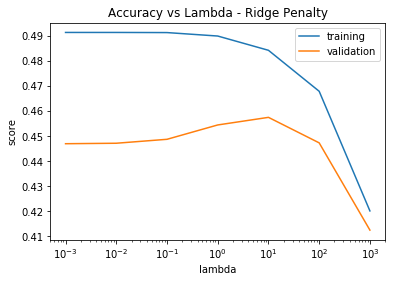

In [29]:
xaxis = [0.001,0.01,0.1,1,10,100,1000] #values of lambda used
plt.plot(xaxis,ridge_score_train, label = 'training')
plt.plot(xaxis,ridge_score_val, label = 'validation')
plt.xlabel('lambda')
plt.ylabel('score')
plt.legend()
plt.xscale('log')
plt.title('Accuracy vs Lambda - Ridge Penalty')

In [30]:
# Lasso Regression
from sklearn.linear_model import Lasso

#initialise arrays to store the scores 
lasso_score_train = np.zeros(7)
lasso_score_val = np.zeros(7)

for i, C in enumerate((1000,100,10,1, 0.1, 0.01,0.001)):
    lasso_regressor = Lasso(alpha=1/C, fit_intercept = True)
    lasso_regressor.fit(X_train,y_train)
    lasso_score_train[i] = lasso_regressor.score(X_train,y_train)
    lasso_score_val[i] = lasso_regressor.score(X_val,y_val)
    
print('training score \n', lasso_score_train)
print('validation score \n', lasso_score_val)

/home/jack/.virtualenvs/cs229/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142642.11338053714, tolerance: 100.72913028081433
  positive)


training score 
 [0.49057317 0.482041   0.44870825 0.34330584 0.         0.
 0.        ]
validation score 
 [ 0.45273163  0.45458929  0.42456451  0.34166222 -0.00081468 -0.00081468
 -0.00081468]


In [32]:
import exp_util

In [39]:
exp_util.val_bin_accuracy(lr_regressor, X_val, y_val)

0.672316384180791

Text(0.5,1,'Accuracy vs Lambda - Ridge Penalty')

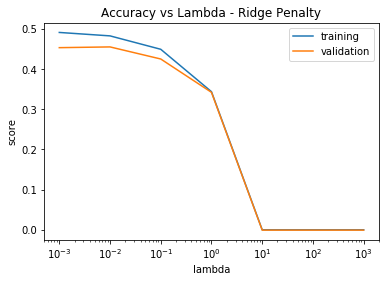

In [31]:
xaxis = [0.001,0.01,0.1,1,10,100,1000] #values of lambda used
plt.plot(xaxis,lasso_score_train, label = 'training')
plt.plot(xaxis,lasso_score_val, label = 'validation')
plt.xlabel('lambda')
plt.ylabel('score')
plt.legend()
plt.xscale('log')
plt.title('Accuracy vs Lambda - Ridge Penalty')

In [ ]:
# non-nested cross validation using RBF SVM
from sklearn.model_selection import GridSearchCV

rbf = SVR(kernel='rbf')
gammas = np.logspace(-6, 0, 7)
params = {'gamma': gammas}
gridcv = GridSearchCV(estimator=rbf, param_grid=params, cv=5)
gridcv.fit(X_trainval, y_trainval)
scores_mean = gridcv.cv_results_['mean_test_score']
scores_sd = gridcv.cv_results_['std_test_score']
print('highest accuracy score is',gridcv.best_score_)
model = gridcv.best_estimator_

In [ ]:
# non-nested cross validation using Ridge
from sklearn.model_selection import GridSearchCV

ridge_regressor = Ridge(fit_intercept = True)
params={'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]}

gridcv = GridSearchCV(estimator=ridge_regressor, param_grid=params, cv=10)
gridcv.fit(X_trainval, y_trainval)
scores_mean = gridcv.cv_results_['mean_test_score']
scores_sd = gridcv.cv_results_['std_test_score']
print('highest accuracy score is',gridcv.best_score_)
model = gridcv.best_estimator_